# TauREx 3.0

## Setup

Lets setup the notebook. If the plots arent interactive then run this part again

In [1]:
import matplotlib.pyplot as plt
%matplotlib notebook
from ipywidgets import *
import numpy as np
import sys

And lets disable logging

In [2]:
import taurex.log
taurex.log.disableLogging()

## Loading cross-sections

We need to point TauREx3 to our cross-sections. This is handled by the caching classes. Once a cross-section is loaded it does not need to be loaded again.
First lets import the classes:

In [3]:
from taurex.cache import OpacityCache,CIACache

Now lets point the xsection and cia cachers to our files:

In [4]:
import numpy as np
import pandas as pd
from scipy import stats
import pprint
import warnings
from pandas.errors import ParserWarning

pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)

import re
import os
from pathlib import Path
import warnings
from typing import List, Dict, Tuple, Any, Union, Callable
from astropy.table import Table, MaskedColumn

from astroquery import mast
from astroquery.mast import Observations
from astropy.time import Time, TimeJD, TimeDelta
from astroquery.mast.missions import MastMissions

hst_mission = MastMissions(mission='hst')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 300

from tqdm import tqdm

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

In [31]:
# local setup
WDIR = Path().cwd().parent.parent

CLEAN_TRANSMISSION_PATH = WDIR / "data/transitspec_with_spectral_elements.csv"
TAUREX_LIGHTCURVE_PATH = WDIR / "data/taurex_lightcurves_LW"

OPACITY_PATH = str(WDIR / "examples/Input/xsec/xsec_sampled_R15000_0.3-15")
CIA_PATH = str(WDIR / "examples/Input/cia/hitran")

# LINELISTS_PATH = WDIR / "data/Linelists/xsec/TauRex_sampled_xsecs_R10000_0.3-15"
# CIA_PATH = WDIR / "data/Linelists/cia/hitran"

In [54]:
# OpacityCache().clear_cache()
OpacityCache().set_opacity_path(OPACITY_PATH)
CIACache().set_cia_path(CIA_PATH)


TauREx3 is now ready to use them! For fun lets, try grabbing the H2O cross-section and plotting it. First tell the OpacityCache function to grab it.

In [55]:
h2o_xsec = OpacityCache()['H2O']

Now we can compute the cross-section for any pressure and temperature!
Lets try 2000K and 10 Pa.

In [56]:
h2o_xsec.opacity(2000, 10)

array([7.02222276e-26, 1.75226371e-26, 3.43125203e-26, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

But why stop there? We can plot the temperature and pressure *interactively*

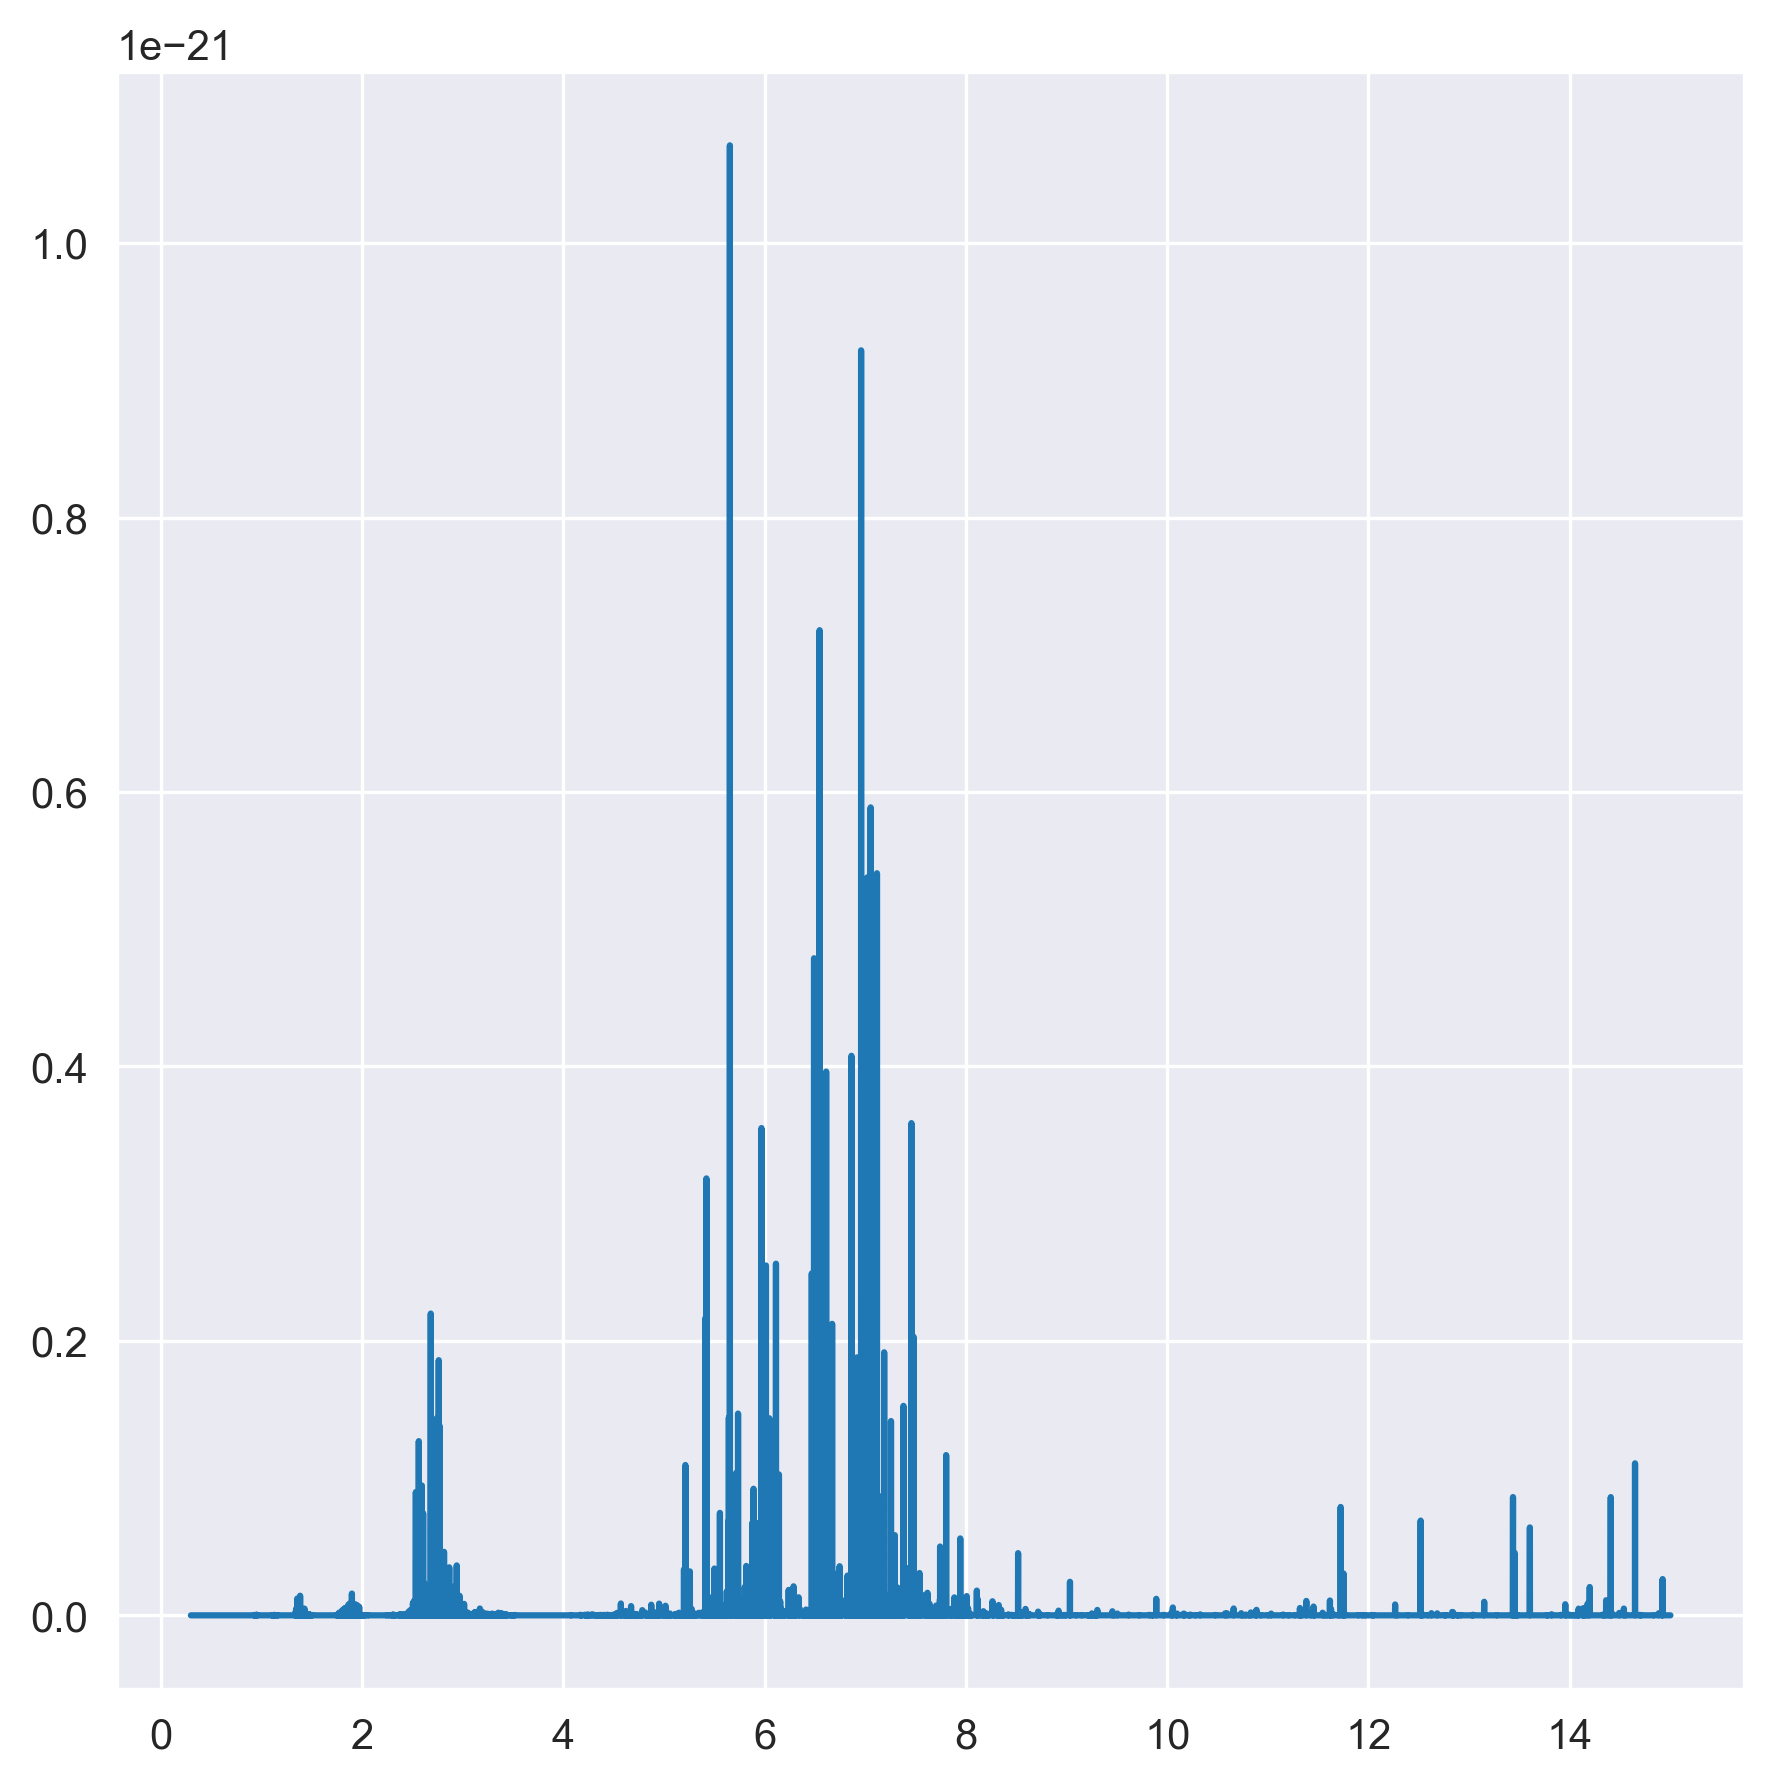

interactive(children=(FloatSlider(value=1500.0, description='temperature', max=2000.0, min=800.0, step=100.0),…

In [57]:
xsec_fig = plt.figure()
xsec_ax = xsec_fig.add_subplot(1,1,1)



xsec, = xsec_ax.plot(10000/h2o_xsec.wavenumberGrid,h2o_xsec.opacity(800,1e0))

def update_cross(temperature=1500.0,pressure=6.7):

    xsec.set_ydata(h2o_xsec.opacity(temperature,10**pressure))
    xsec_ax.relim();
    xsec_ax.autoscale_view()
    xsec_fig.canvas.draw()

interact(update_cross,temperature=(800.0,2000.0,100),pressure=(-1.0,10.0,1));

## Profiles

Now we need to setup our forward model. Lets create a temperature profile, we will use the Guillot profile but other brands are available:

In [58]:
from taurex.temperature import Guillot2010
guillot = Guillot2010(T_irr=1200.0)

Now lets do the same for our planet:

In [59]:
from taurex.planet import Planet
planet = Planet(planet_radius=1.0,planet_mass=1.0)

and the planets star:

In [60]:
from taurex.stellar import BlackbodyStar

star = BlackbodyStar(temperature=5700.0,radius=1.0)

Now we need to define a chemistry profile, first lets setup the chemical model, we're going for the free-type model so we'll use *TaurexChemistry* which allows us to freely add any molecule:

In [61]:
from taurex.chemistry import TaurexChemistry
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)

#### Adding molecules

Now we need to add some molecules. This is accomplished by the *addGas* function. We can create varius types of gas profiles
for each molecule and add them in. Lets try the constant profile for H2O:

In [62]:
from taurex.chemistry import ConstantGas

h2o = ConstantGas('H2O',mix_ratio=1.2e-4)
chemistry.addGas(h2o)


We can also create the gas on the spot as well:

In [63]:
chemistry.addGas(ConstantGas('N2',mix_ratio=3.00739e-9))


And we're done for profiles! Like the cross-sections you can use them in isolation for your own evil deeds. Some require initialization with other profiles like pressure and altitude, you can find how to use them in the API documentation. An easy example are stars. Maybe you want to use the [**PHOENIX**](https://phoenix.ens-lyon.fr/Grids/BT-Settl/CIFIST2011_2015/FITS/) star library but don't want to bother coding the function to load and interpolate. Well you can just have *Taurex3* handle it for you!

In [64]:
from taurex.stellar import PhoenixStar
## 
anotherstar = PhoenixStar(phoenix_path='/path/to/phoenix/BT-Settl_M-0.0a+0.0',temperature=5200.0)
star_fig = plt.figure()
star_ax = star_fig.add_subplot(1,1,1)

star_wngrid = np.linspace(0,100000,1000)

anotherstar.initialize(star_wngrid)

pstar, = star_ax.plot(anotherstar.spectralEmissionDensity)

def update_cross(temperature=5200.0):
    anotherstar.temperature=temperature
    anotherstar.initialize(star_wngrid)
    
    pstar.set_ydata(anotherstar.spectralEmissionDensity)
    star_ax.relim();
    star_ax.autoscale_view()
    star_fig.canvas.draw()

interact(update_cross,temperature=(800.0,8000.0,400));


taurex.PhoenixStar - ERROR - In: __init__()/line:52 - No file path or incorrect path to phoenix files defined - None


Exception: No file path or incorrect path to phoenix files defined - None

After that quick detour lets carry on with our goal.

## Building the model

Now we can build our transmission model! Lets first create our transmission model and add our profiles to them:


In [96]:
from taurex.model import TransmissionModel
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

At this point our atmosphere has profiles but no physics! We can add this by including some contributions. Lets add in Absorption:

In [97]:
from taurex.contributions import AbsorptionContribution
tm.add_contribution(AbsorptionContribution())

And some CIA for good measure:

In [98]:
# OpacityCache().set_opacity_path(OPACITY_PATH)
# CIACache().set_cia_path(CIA_PATH)

OpacityCache().set_opacity_path(OPACITY_PATH)
CIACache().set_cia_path(CIA_PATH)
CIACache().load_cia_from_path(CIA_PATH)

taurex.CIACache - ERROR - In: add_cia()/line:88 - cia with name H2-H2 already in opactiy dictionary dict_keys(['H2-H2', 'H2-HE'])


Exception: cia for molecule %s already exists

In [99]:
from taurex.contributions import CIAContribution
print(CIACache().cia_dict)
cia_contrib = CIAContribution(cia_pairs=['H2-H2','H2-He'])
print(cia_contrib.ciaPairs)
tm.add_contribution(cia_contrib)
# print(CIAContribution(cia_pairs=['H2-H2','H2-He']))

{'H2-H2': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, 'H2-HE': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>}
['H2-H2', 'H2-He']


In [106]:
CIACache().cia_dict["H2-He"] = CIACache().cia_dict["H2-HE"]
print(cia_contrib.ciaPairs)

print(CIACache().cia_dict)

['H2-H2', 'H2-He']
{'H2-H2': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, 'H2-HE': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>, 'H2-He': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>}


In [112]:
print(cia_contrib._cia_pairs)
print(CIACache().cia_dict)

['H2-H2', 'H2-He']
{'H2-H2': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, 'H2-HE': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>, 'H2-He': <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>}


And some rayleigh

In [107]:
from taurex.contributions import RayleighContribution
tm.add_contribution(RayleighContribution())

Finally, putting it all together we **build** it to setup all the profiles

In [117]:
tm.build()

In [118]:
tm.cia_dict

{}

Thats it! Our transmission model is complete! We can now run it:

In [128]:
print(cia_contrib.ciaPairs)
print(cia_contrib._cia_cache)
print(cia_contrib._cia_pairs)
print(cia_contrib._total_cia)

# del CIACache().cia_dict["H2-HE"]
print(CIACache().cia_dict)

res = tm.model()
res

['H2-H2', 'H2-He']
['H2-H2', 'H2-He']
2
{}
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
calling from cia.py prepare_each
cia.py - ['H2-H2', 'H2-He'], checking H2-H2 - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, total:  2
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
cia.py - ['H2-H2', 'H2-He'], checking H2-He - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>, total:  2
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
HE
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
He
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
He
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
N2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
N2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He'

(array([  666.63560492,   666.6800473 ,   666.72449263, ...,
        33328.88933329, 33331.11125925, 33333.33333333]),
 array([0.01093933, 0.01094079, 0.01094837, ..., 0.01099453, 0.01099454,
        0.01099456]),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         6.08239452e-006, 6.08239452e-006, 6.08239452e-006],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.32305397e-239, 1.12872519e-239, 9.62892874e-240],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         2.80047135e-151, 2.53285572e-151, 2.29074397e-151],
        ...,
        [9.99953712e-001, 9.99985875e-001, 9.99961105e-001, ...,
         9.96571200e-001, 9.96570202e-001, 9.96569205e-001],
        [9.99974977e-001, 9.99992692e-001, 9.99979205e-001, ...,
         9.98093987e-001, 9.98093432e-001, 9.98092877e-001],
        [9.99989344e-001, 9.99996961e-001, 9.99991197e-001, ...,
         9.99175973e-001, 9.99175733e-001, 9.99175493e-001]]),
 None)

Nice! The output has four components:

- The wavenumber grid
- The *native* flux
- The optical depth
- Any extra information

Now lets plot it! Lets see the chemistry of the atmosphere:

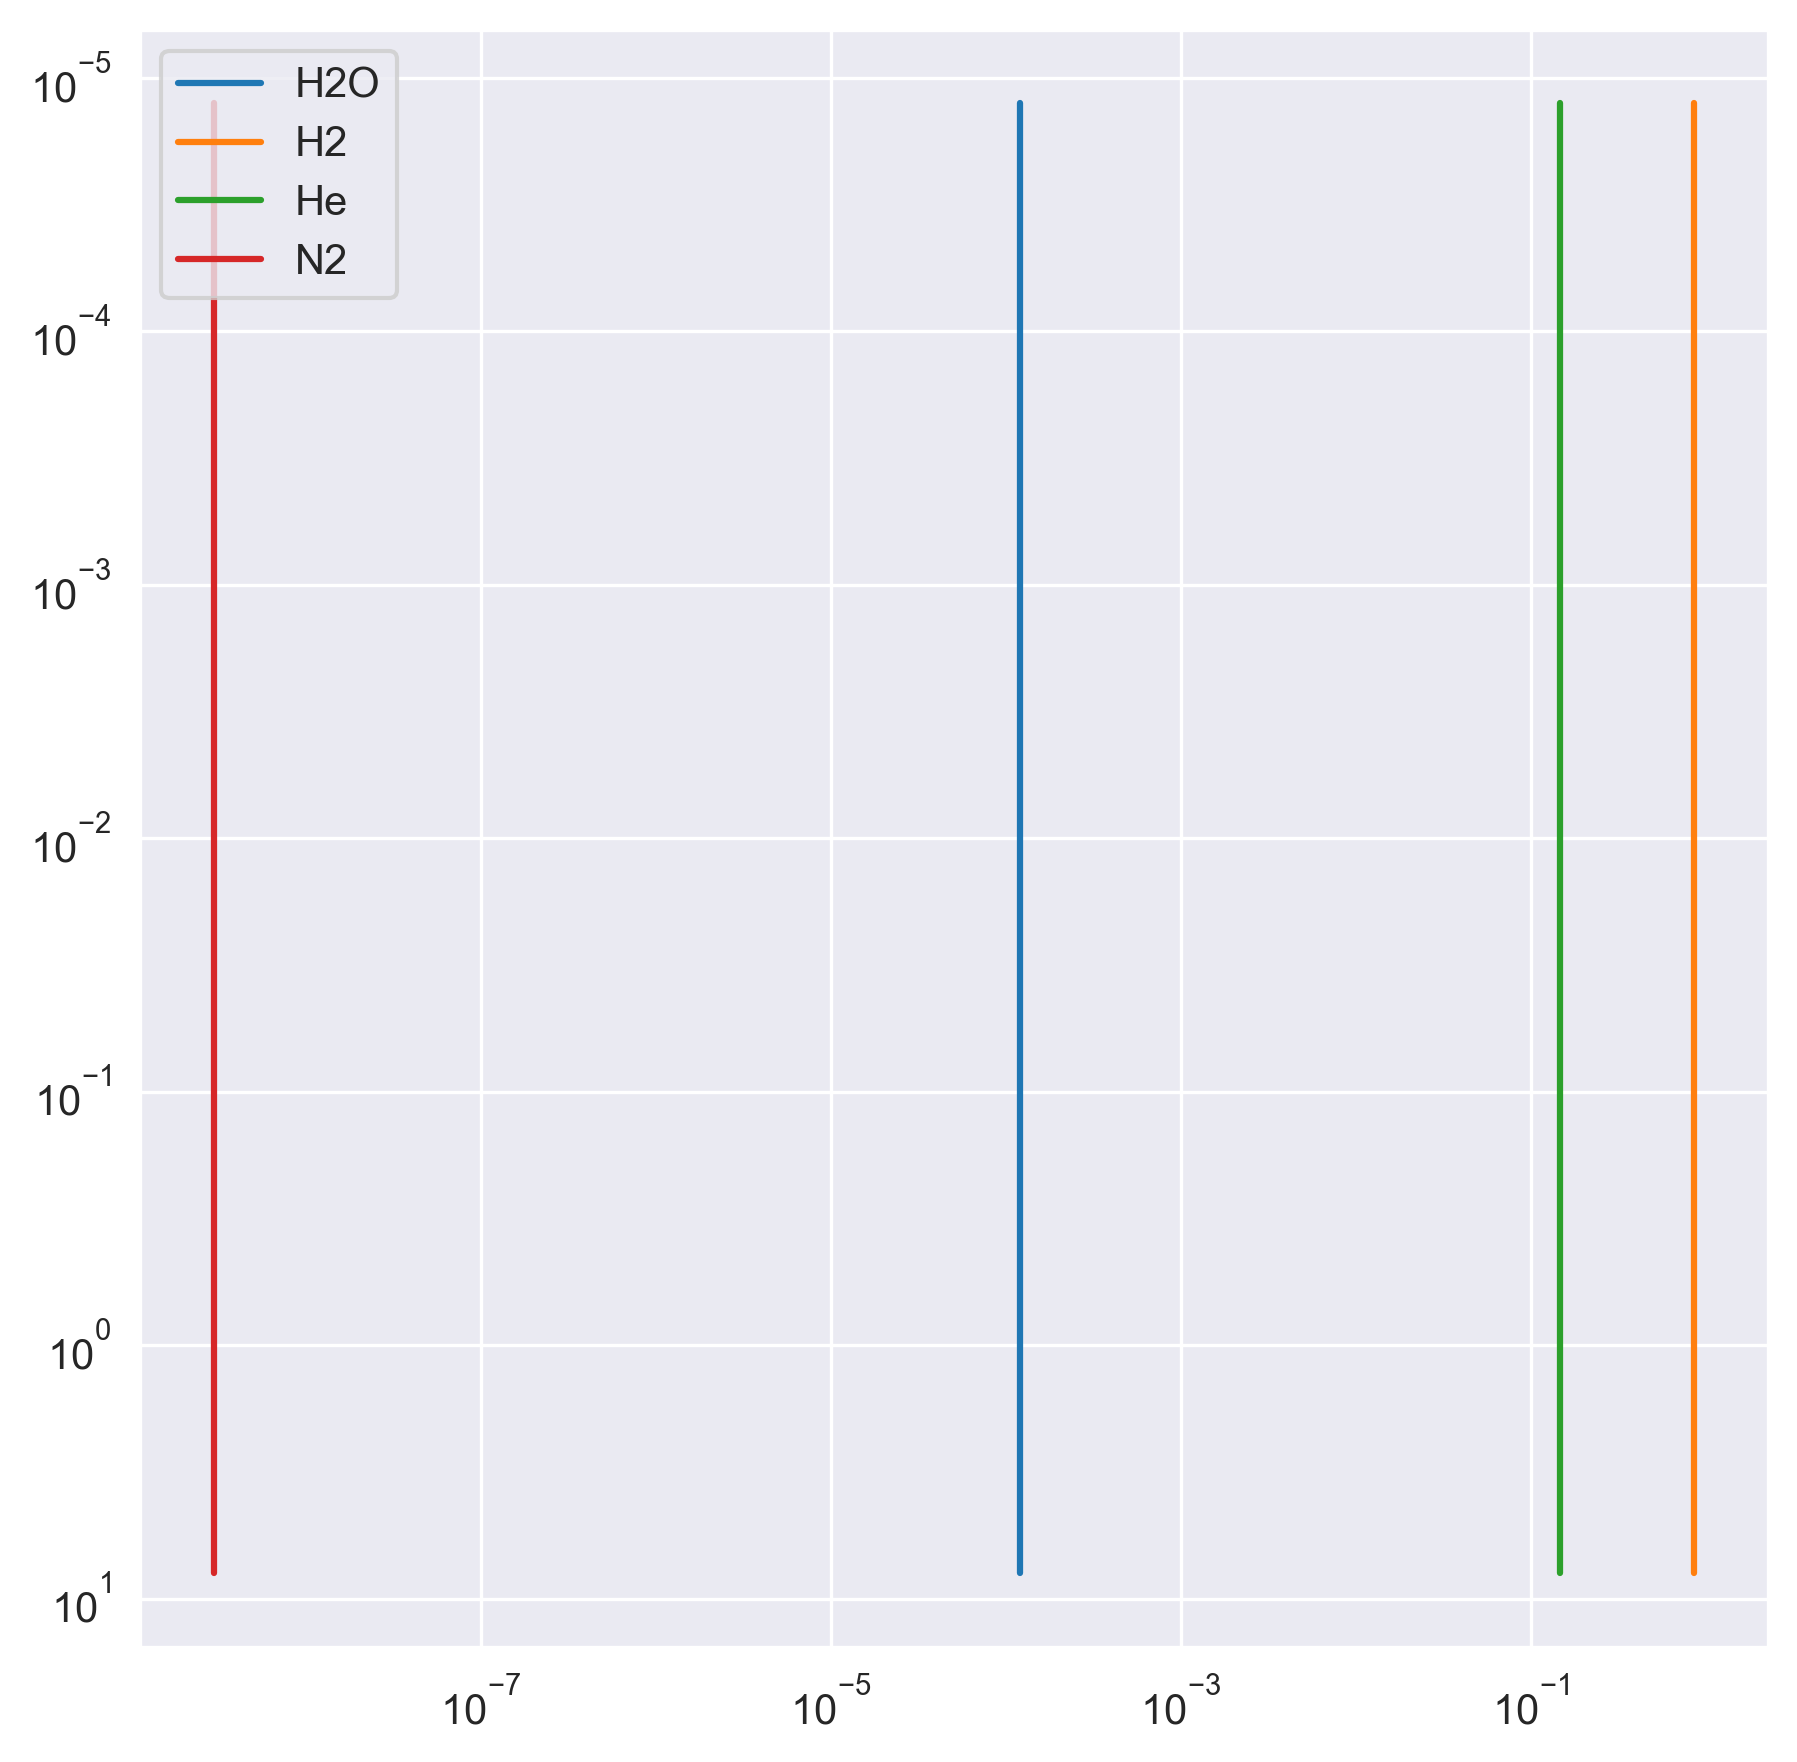

In [129]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

Not interesting, but our chemistry model is pretty simple!

And now lets plot the flux

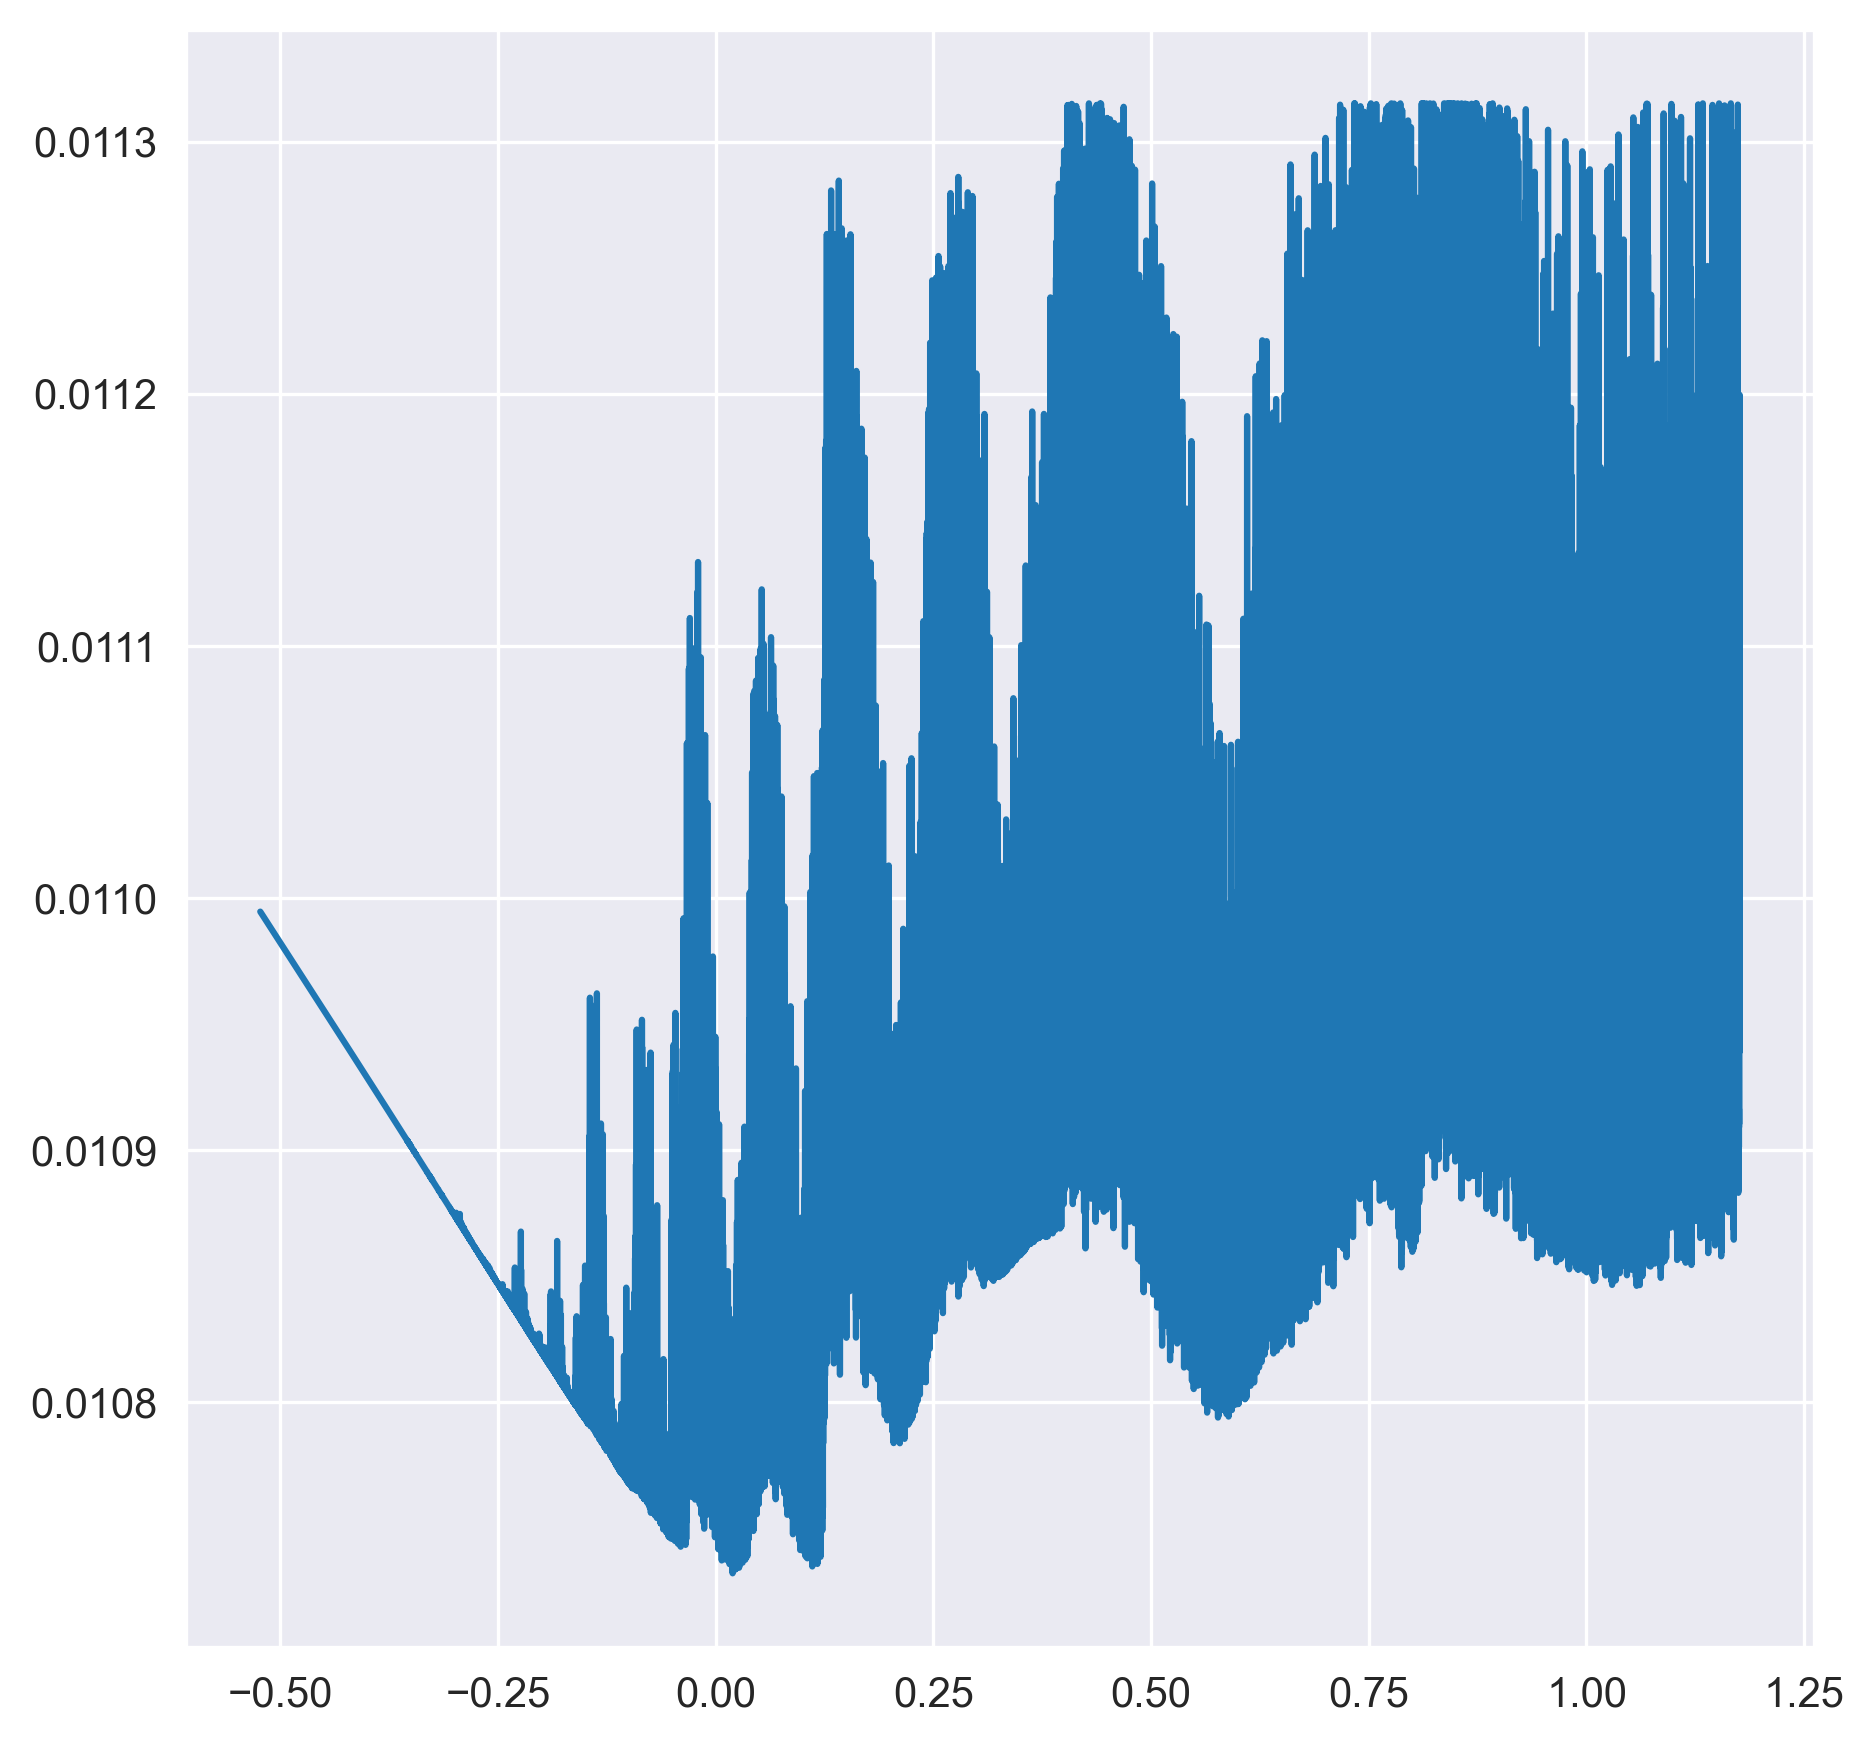

In [130]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()

Coool! But lets try binning. We will use a simple but fast binner *SimpleBinner*.

H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
calling from cia.py prepare_each
cia.py - ['H2-H2', 'H2-He'], checking H2-H2 - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, total:  2
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
cia.py - ['H2-H2', 'H2-He'], checking H2-He - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>, total:  2
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
HE
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
He
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
He
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
N2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
N2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2

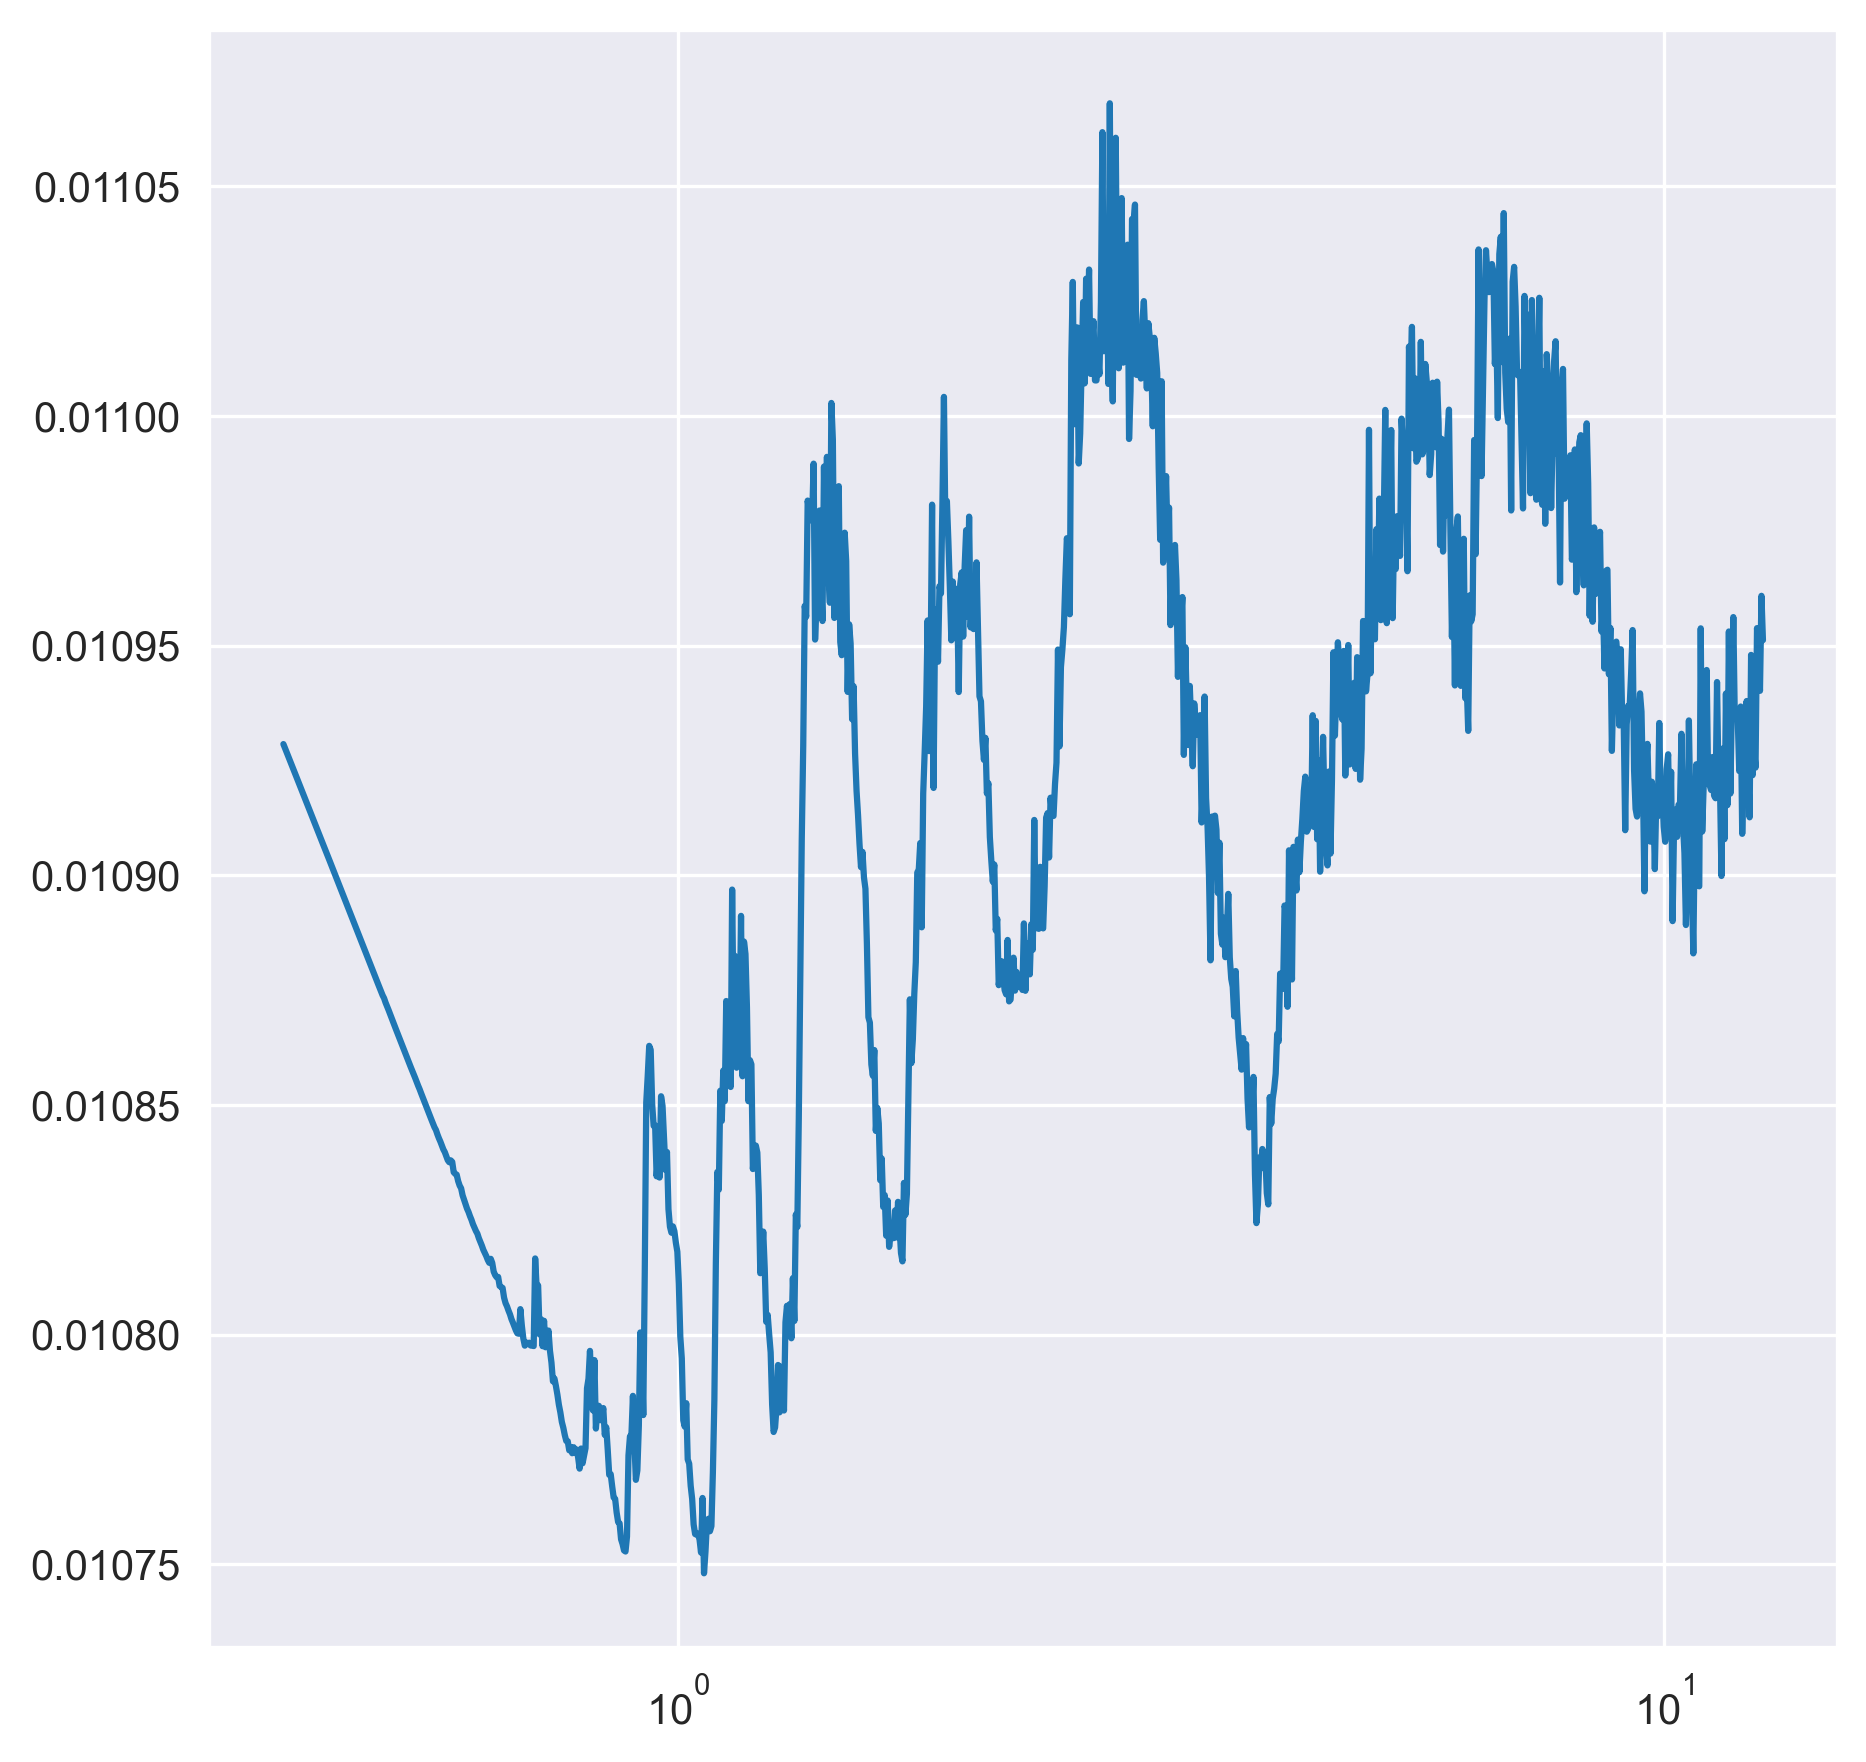

In [131]:
from taurex.binning import FluxBinner, SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()

Cool but the nice thing about TauREx is that you can alter any of the parameters and it will respond to it!


If any of the profiles are altered then model will respond to it. This means that parameters such as temperature and mix ratios and even contributions can be changed on the fly! Try this example out

H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
calling from cia.py prepare_each
cia.py - ['H2-H2', 'H2-He'], checking H2-H2 - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, total:  2
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
cia.py - ['H2-H2', 'H2-He'], checking H2-He - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>, total:  2
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
HE
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
He
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
He
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
N2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
N2
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2', 'He', 'N2')
=====
H2O
must be in:
('H2O',)
('H2

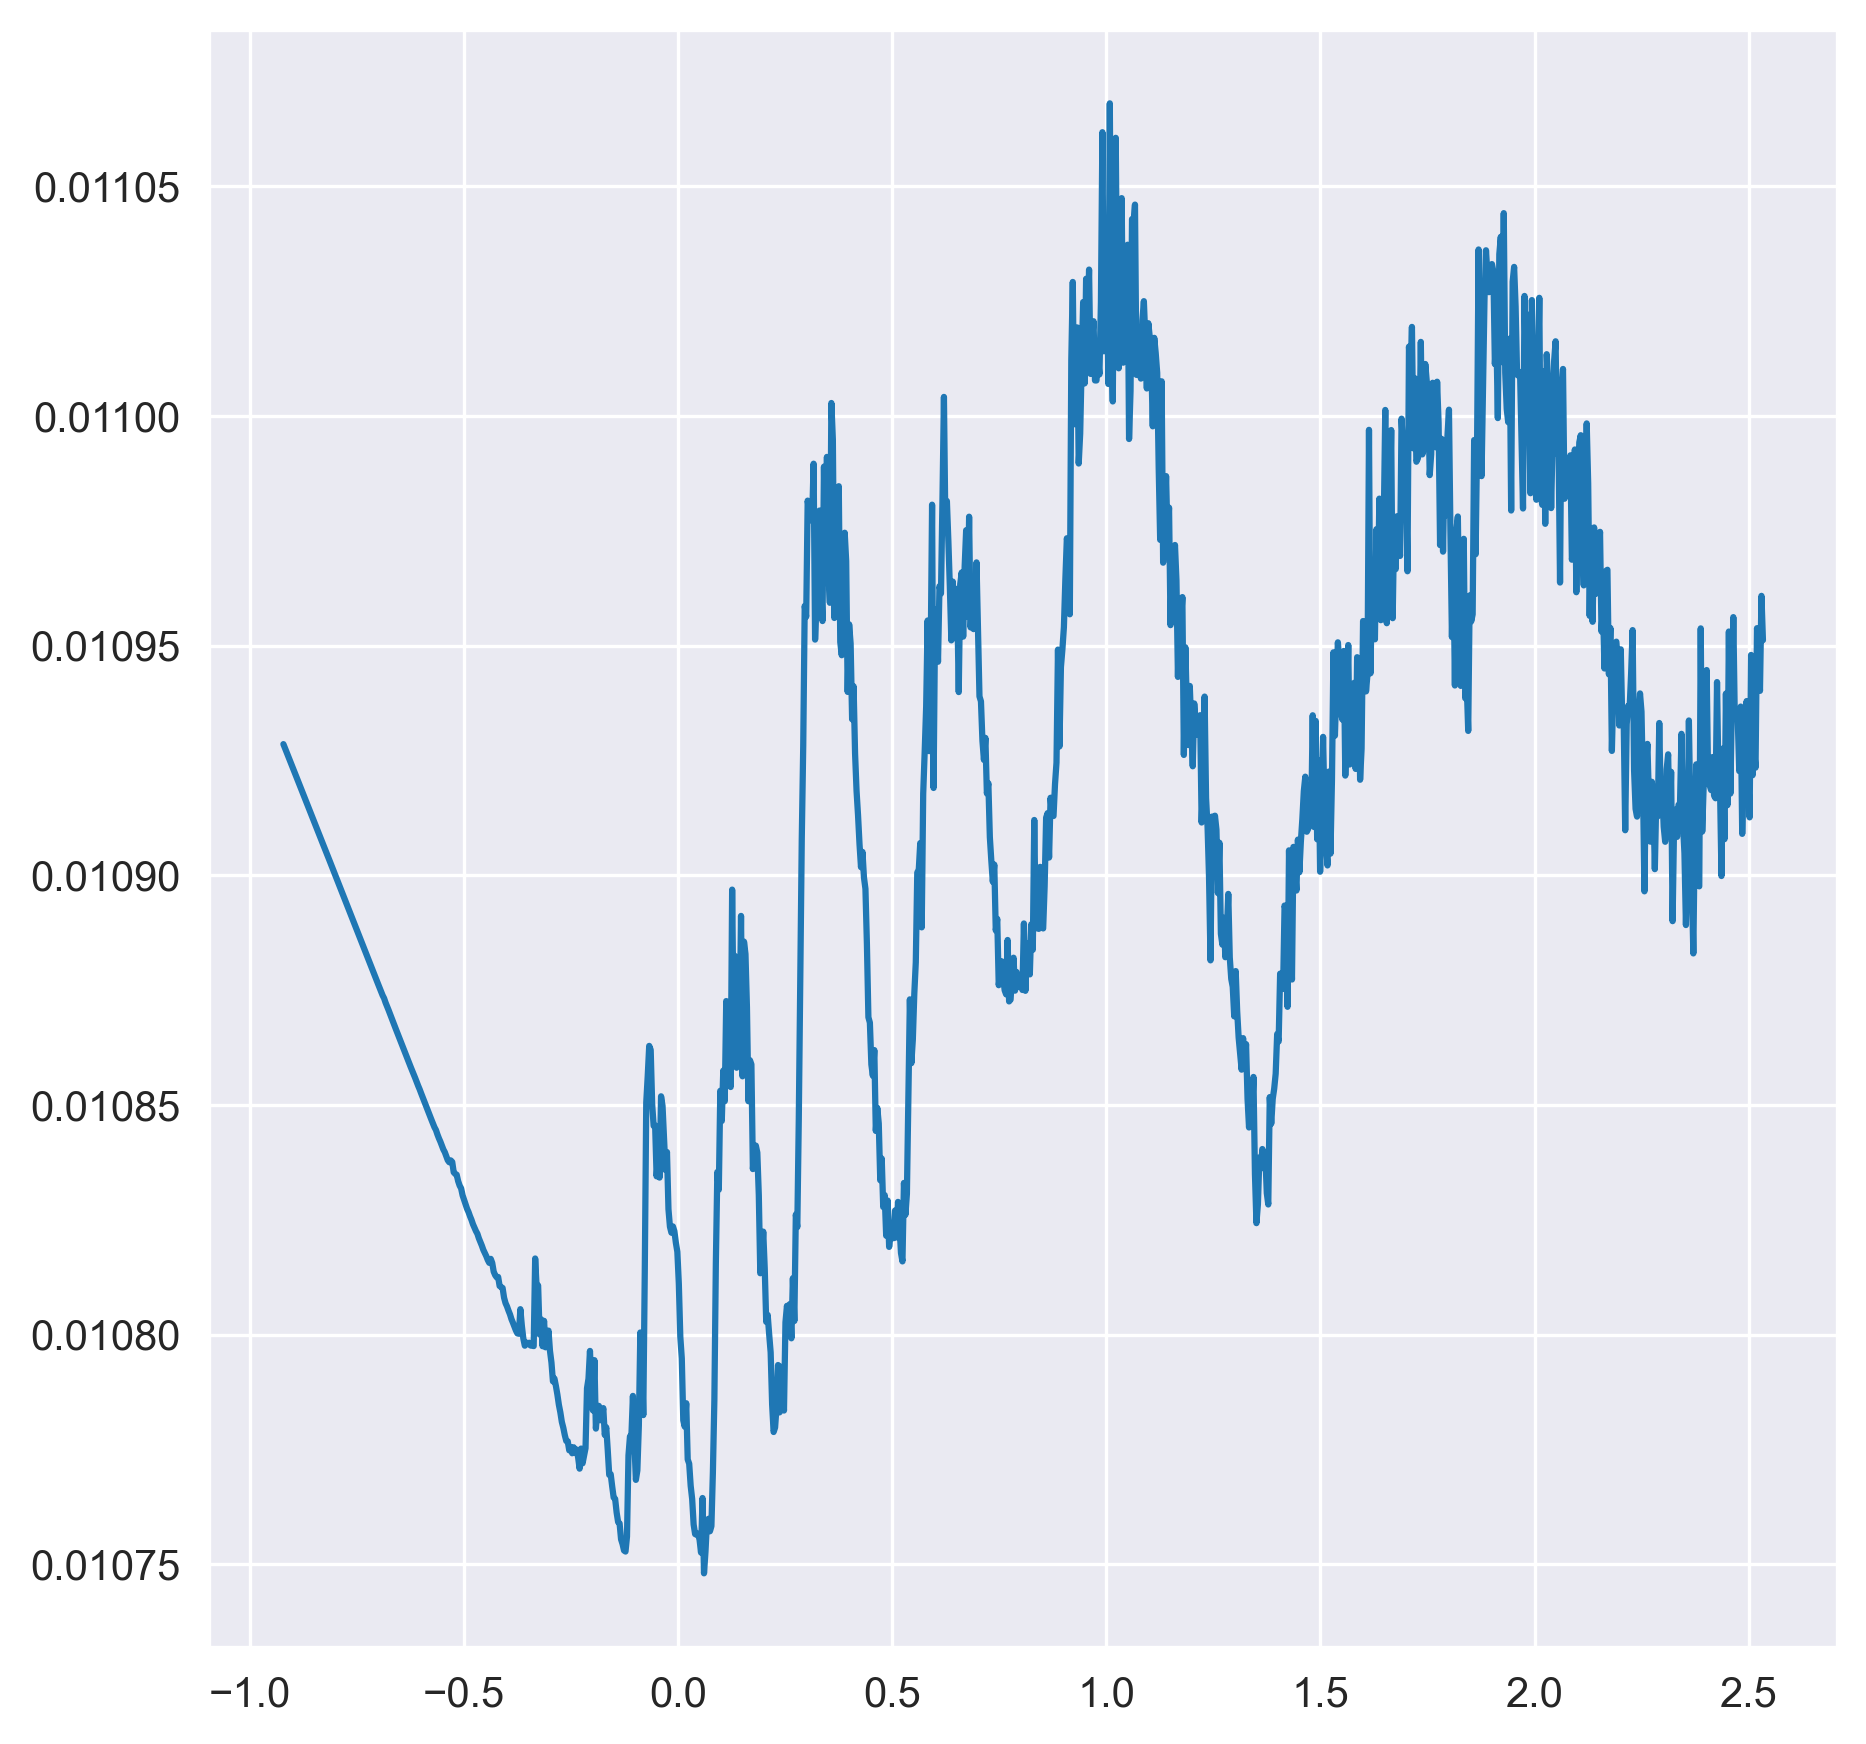

interactive(children=(FloatSlider(value=1500.0, description='temperature', max=2000.0, min=800.0, step=100.0),…

In [132]:
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

model, = ax.plot(np.log(10000/wngrid),bn.bin_model(tm.model(wngrid))[1])

def update_model(temperature=1500.0,h2o_mix=-4):
    guillot.equilTemperature = temperature
    tm['H2O'] = 10**h2o_mix
    model.set_ydata(bn.bin_model(tm.model(wngrid))[1])
    ax.relim();
    ax.autoscale_view()
    fig.canvas.draw()

interact(update_model,temperature=(800.0,2000.0,100),h2o_mix=(-7.0,-2.0,1));


You can do some crazy things! If you reuse the same profiles on other models. You essentially couple them! That means
you can have multiple model that all alter at the same time! We can see the equivalant Emission and Direct image spectrum like so:

In [133]:
from taurex.model import EmissionModel, DirectImageModel
em = EmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
di = DirectImageModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

em.add_contribution(AbsorptionContribution())
em.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
em.add_contribution(RayleighContribution())

di.add_contribution(AbsorptionContribution())
di.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
di.add_contribution(RayleighContribution())

em.build()
di.build()

calling from cia.py prepare_each
cia.py - ['H2-H2', 'H2-He'], checking H2-H2 - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8AAE0580>, total:  2
cia.py - ['H2-H2', 'H2-He'], checking H2-He - cia: <taurex.cia.picklecia.PickleCIA object at 0x000001EB8975DBB0>, total:  2


taurex.CIACache - ERROR - In: __getitem__()/line:43 - CIA for pair H2-H2 could not be loaded
taurex.CIACache - ERROR - In: __getitem__()/line:43 - It could not be found in the local dictionary  []
taurex.CIACache - ERROR - In: __getitem__()/line:43 - Or paths None
taurex.CIACache - ERROR - In: __getitem__()/line:43 - Try loading it manually/ putting it in a path


calling from cia.py prepare_each


Exception: cia could notn be loaded

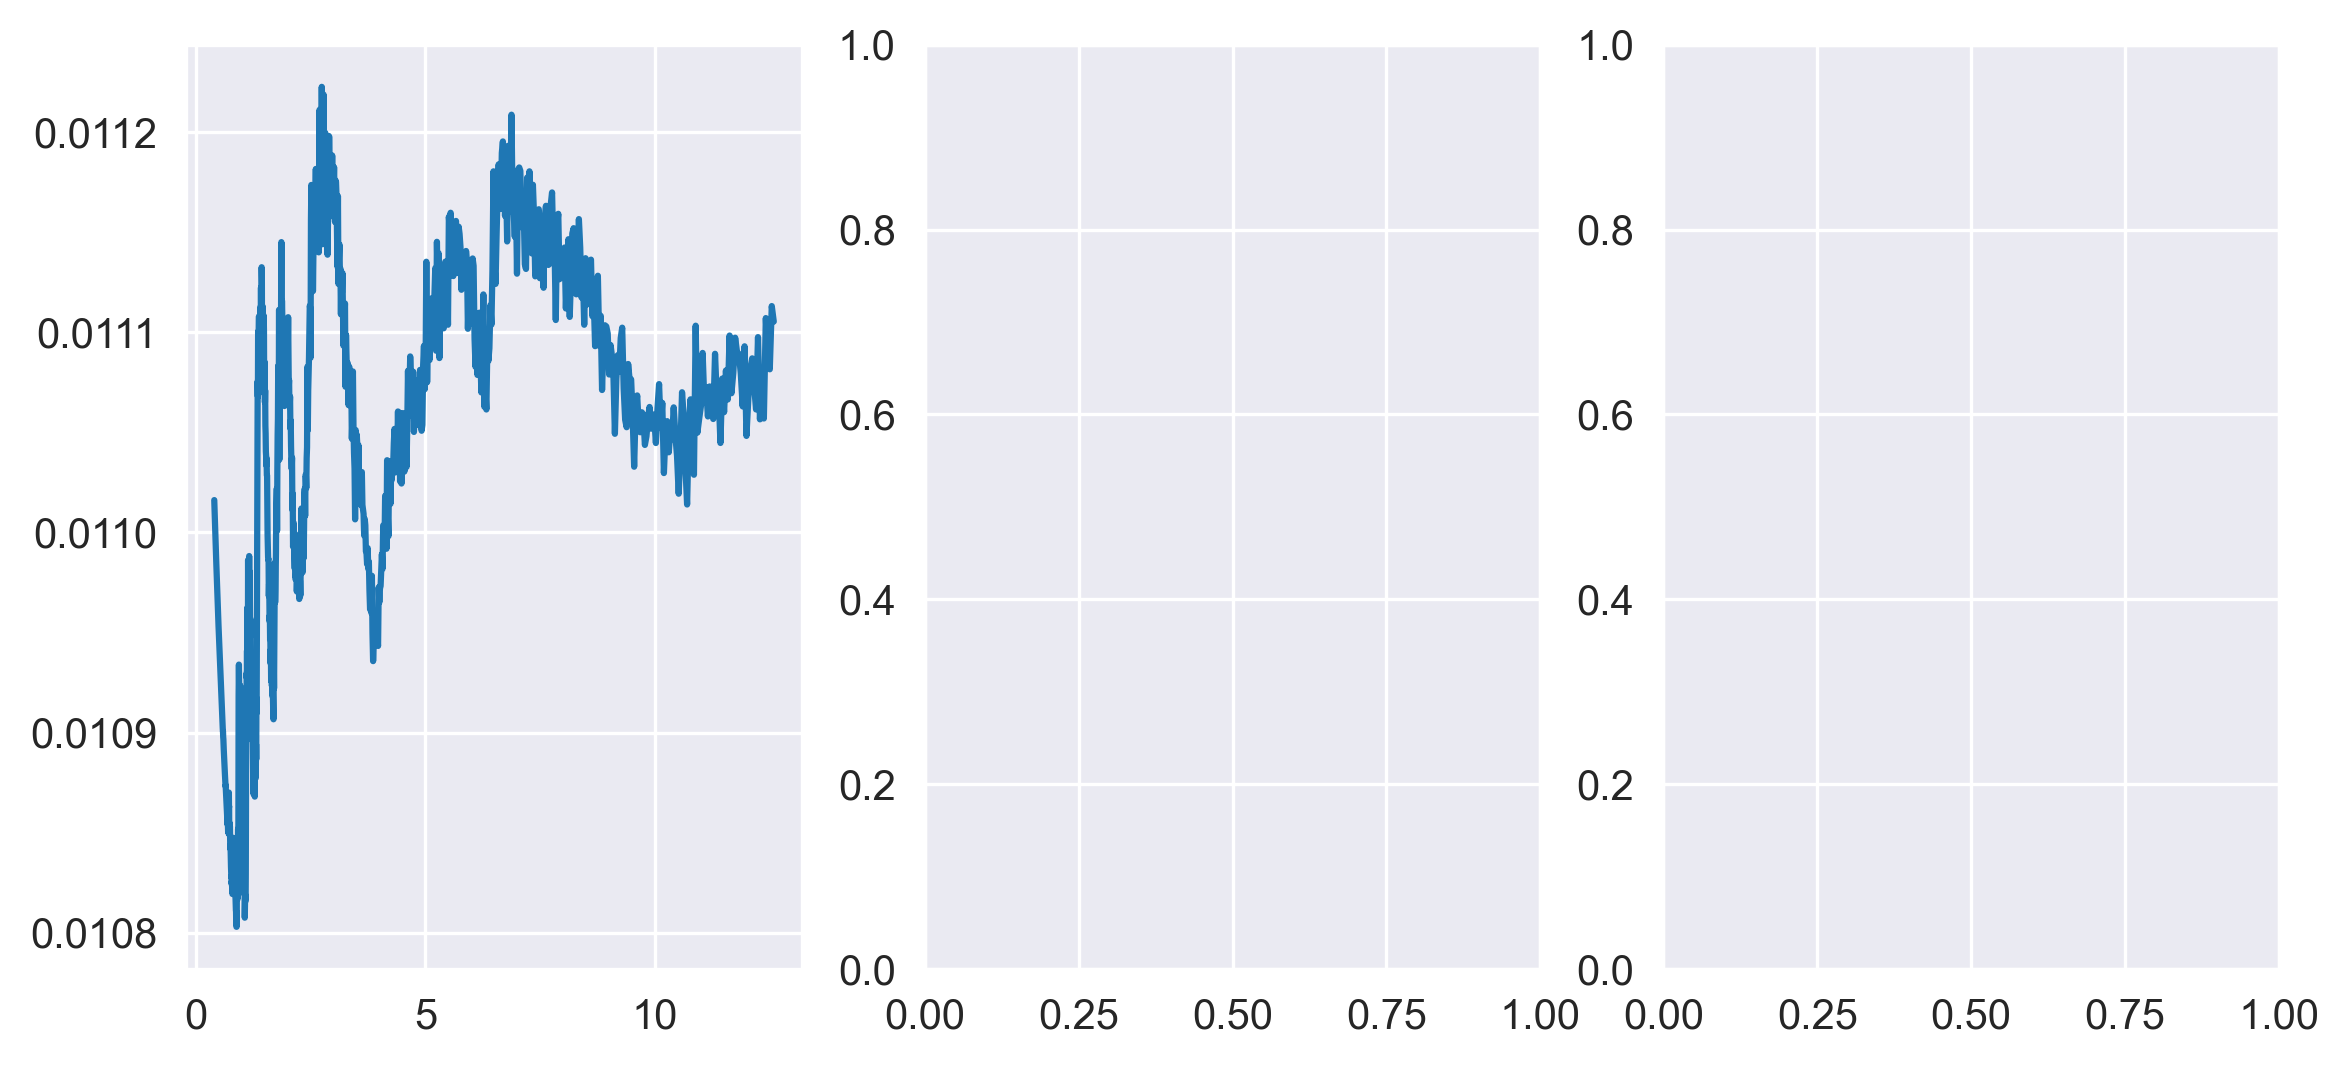

In [134]:
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))

all_fig = plt.figure(figsize=(9,4))
tm_ax = all_fig.add_subplot(1,3,1)
em_ax = all_fig.add_subplot(1,3,2)
di_ax = all_fig.add_subplot(1,3,3)
model_tm, = tm_ax.plot(10000/wngrid,bn.bin_model(tm.model(wngrid))[1])
model_em, = em_ax.plot(10000/wngrid,bn.bin_model(em.model(wngrid))[1])
model_di, = di_ax.plot(10000/wngrid,bn.bin_model(di.model(wngrid))[1])
tm_ax.set_xscale('log')
em_ax.set_xscale('log')
di_ax.set_xscale('log')
tm_ax.set_title('Transmission')
em_ax.set_title('Emission')
di_ax.set_title('Direct Image')
tm_ax.set_xlabel('Wavelength (um)')
em_ax.set_xlabel('Wavelength (um)')
di_ax.set_xlabel('Wavelength (um)')

def update_model(temperature=1500.0,h2o_mix=-4):
    guillot.equilTemperature = temperature
    tm['H2O'] = 10**h2o_mix
    model_tm.set_ydata(bn.bin_model(tm.model(wngrid))[1])
    model_em.set_ydata(bn.bin_model(em.model(wngrid))[1])
    model_di.set_ydata(bn.bin_model(di.model(wngrid))[1])
    tm_ax.relim();
    tm_ax.autoscale_view()
    
    em_ax.relim();
    em_ax.autoscale_view()
    
    di_ax.relim();
    di_ax.autoscale_view()
    
    fig.canvas.draw()

interact(update_model,temperature=(800.0,2000.0,100),h2o_mix=(-7.0,-2.0,1));

## Retreivals

To see what parameters available for retrievals we can list them like so:

In [82]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T_irr',
 'kappa_irr',
 'kappa_v1',
 'kappa_v2',
 'alpha',
 'H2O',
 'N2',
 'He_H2']

The thing is, this is *dynamic*, TauREx 3 figures out what can be fit based on whats in it. Lets throw an
isothermal profile instead:

In [83]:
from taurex.temperature import Isothermal

isothermal = Isothermal(T=1500.0)

tm = TransmissionModel(planet=planet,
                       temperature_profile=isothermal,
                       chemistry=chemistry,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())
tm.build()

In [84]:
tm.model()

(array([  666.61240713,   666.67906837,   666.74573628, ...,
        33326.66766653, 33330.0003333 , 33333.33333333]),
 array([0.01052613, 0.01063063, 0.01056525, ..., 0.01052609, 0.01052612,
        0.01052615]),
 array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         6.43132652e-006, 6.43132806e-006, 6.43124781e-006],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.42570291e-110, 1.27917056e-110, 1.14762904e-110],
        [0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         1.07604140e-069, 1.00473066e-069, 9.38108083e-070],
        ...,
        [9.99796601e-001, 9.95780957e-001, 9.98087394e-001, ...,
         9.98554699e-001, 9.98554068e-001, 9.98553436e-001],
        [9.99887426e-001, 9.97654304e-001, 9.98937920e-001, ...,
         9.99196758e-001, 9.99196407e-001, 9.99196056e-001],
        [9.99951499e-001, 9.98986426e-001, 9.99541444e-001, ...,
         9.99653022e-001, 9.99652870e-001, 9.99652719e-001]]),
 None)

In [85]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T',
 'H2O',
 'N2',
 'He_H2']

Here we lost the Guillot parameters like *T_irr* but gained the Isothermal parameter *T*
We can also access them directly from the model using the brackets operator:

In [86]:
tm['T']

1500.0

And set them

In [87]:
tm['H2O']=1.2e-4

Now we'll need an observation. lets use *ObservedSpectrum* to load a text one from **examples/test_data.dat**:

In [88]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum('path/to/test_data.dat')

Convieniently we have a way of binning our native spectrum down to the observation by calling its *create_binner* method:

In [89]:
obin = obs.create_binner()

And we can now plot

<IPython.core.display.Javascript object>


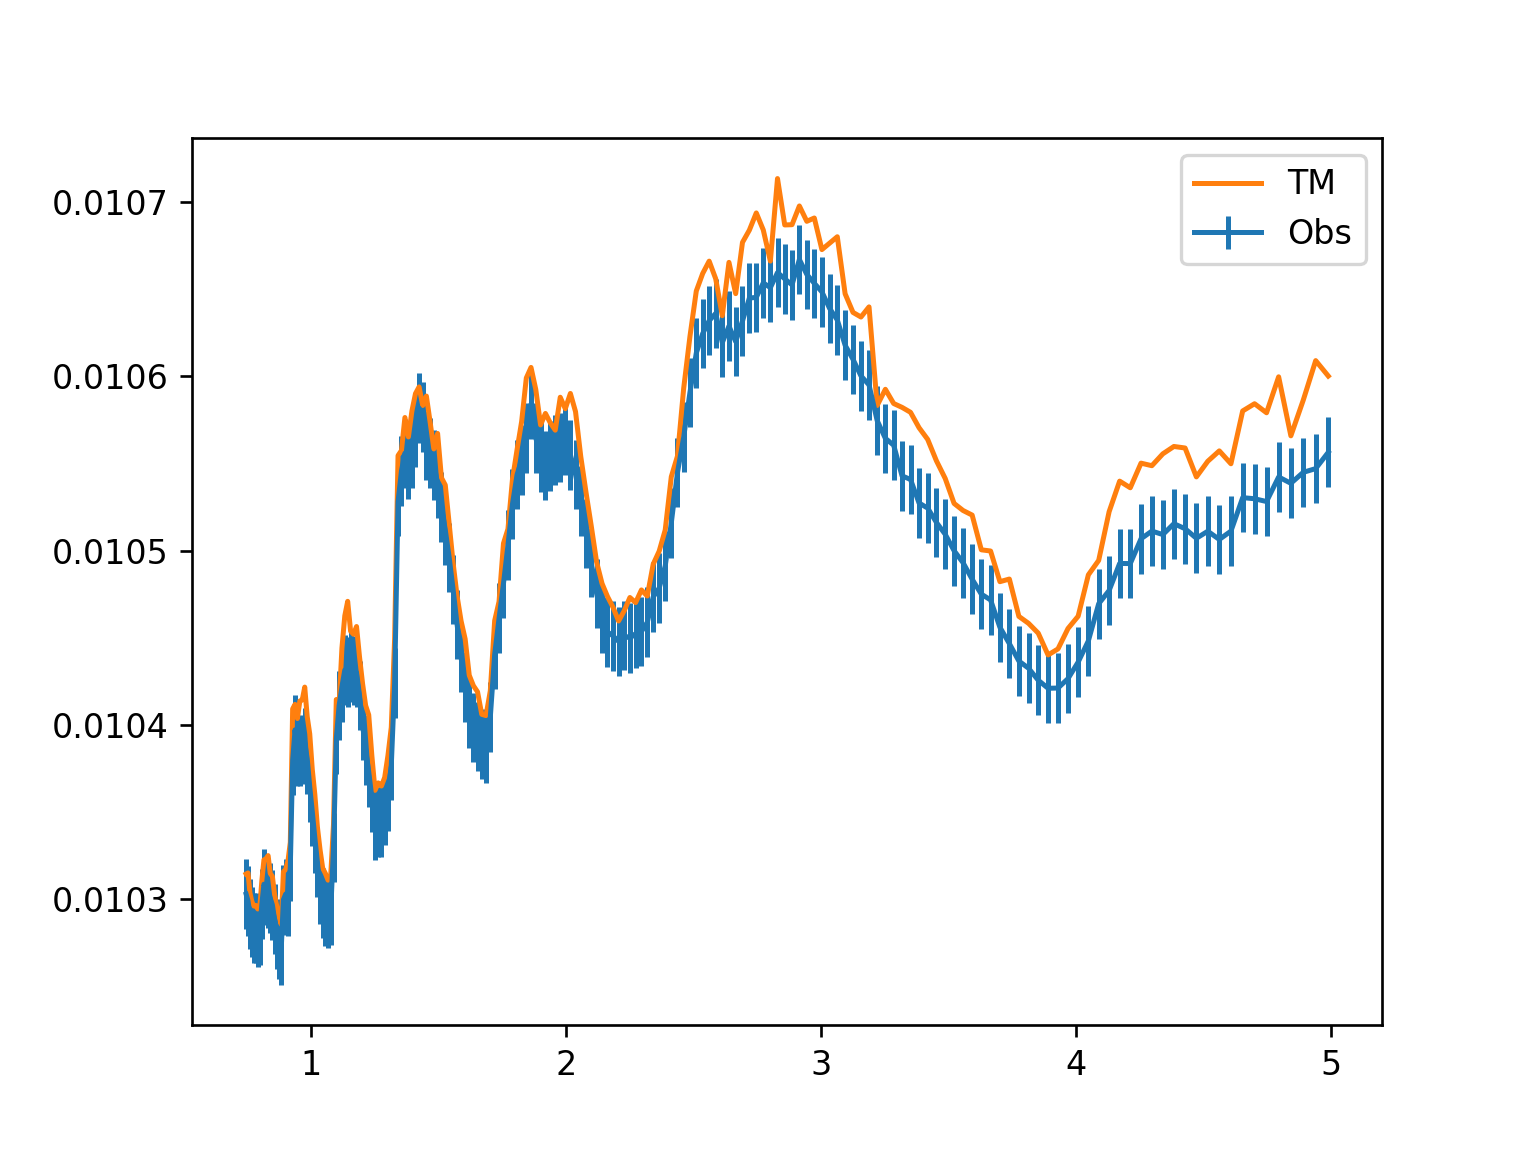

In [90]:
plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
plt.legend()
plt.show()

Ew not good! Lets try a retrieval! We have many optimizers to choose so lets create one using the inbuilt optimizer based on [nestle](http://kylebarbary.com/nestle/)

In [91]:
from taurex.optimizer.nestle import NestleOptimizer
opt = NestleOptimizer(num_live_points=50)

In [92]:
opt.set_model(tm)
opt.set_observed(obs)

In [93]:
opt.enable_fit('planet_radius')
opt.enable_fit('T')
opt.set_boundary('T',[1000,2000])
opt.set_boundary('planet_radius',[0.8,2.1])

In [94]:
solution = opt.fit()
taurex.log.disableLogging()

it=   663 logz=1867.323389811400

taurex.Nestle - INFO - Sampling time 85.49567294120789 s
taurex.Nestle - INFO - Generating spectra and profiles
taurex.Nestle - INFO - Computing solution 0
taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done


niter: 664
ncall: 1096
nsamples: 714
logz: 1867.763 +/-  0.478
h: 11.444


taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.Absorption - INFO - Done
taurex.CIA - INFO - Computing CIA 
taurex.CIA - INFO - Done
taurex.Rayleigh - INFO - Done
taurex.TransmissionModel - INFO - Computing pressure profile
taurex.ChemistryModel - INFO - Initializing chemistry model
taurex.TransmissionModel - INFO - Modelling each contribution.....
taurex.Absorption - INFO - Recomputing active gas H2O opacity
taurex.TransmissionModel - INFO - 	Absorption---H2O contribtuion
taurex.CIA - INFO - Computing CIA 
taurex.TransmissionModel - INFO - 	CIA---H2-H2 contribtuion
taurex.TransmissionModel - INFO - 	CIA---H2-He contribtuion
taurex.TransmissionModel - INFO - 	Rayleigh---H2O contribtuion
taurex.TransmissionModel - INFO - 	Rayleigh---N2 contribtuion
taurex.TransmissionModel - INFO - 	Rayleigh---H2 contribtuion
taurex.TransmissionModel - INFO - 	Ray

<IPython.core.display.Javascript object>


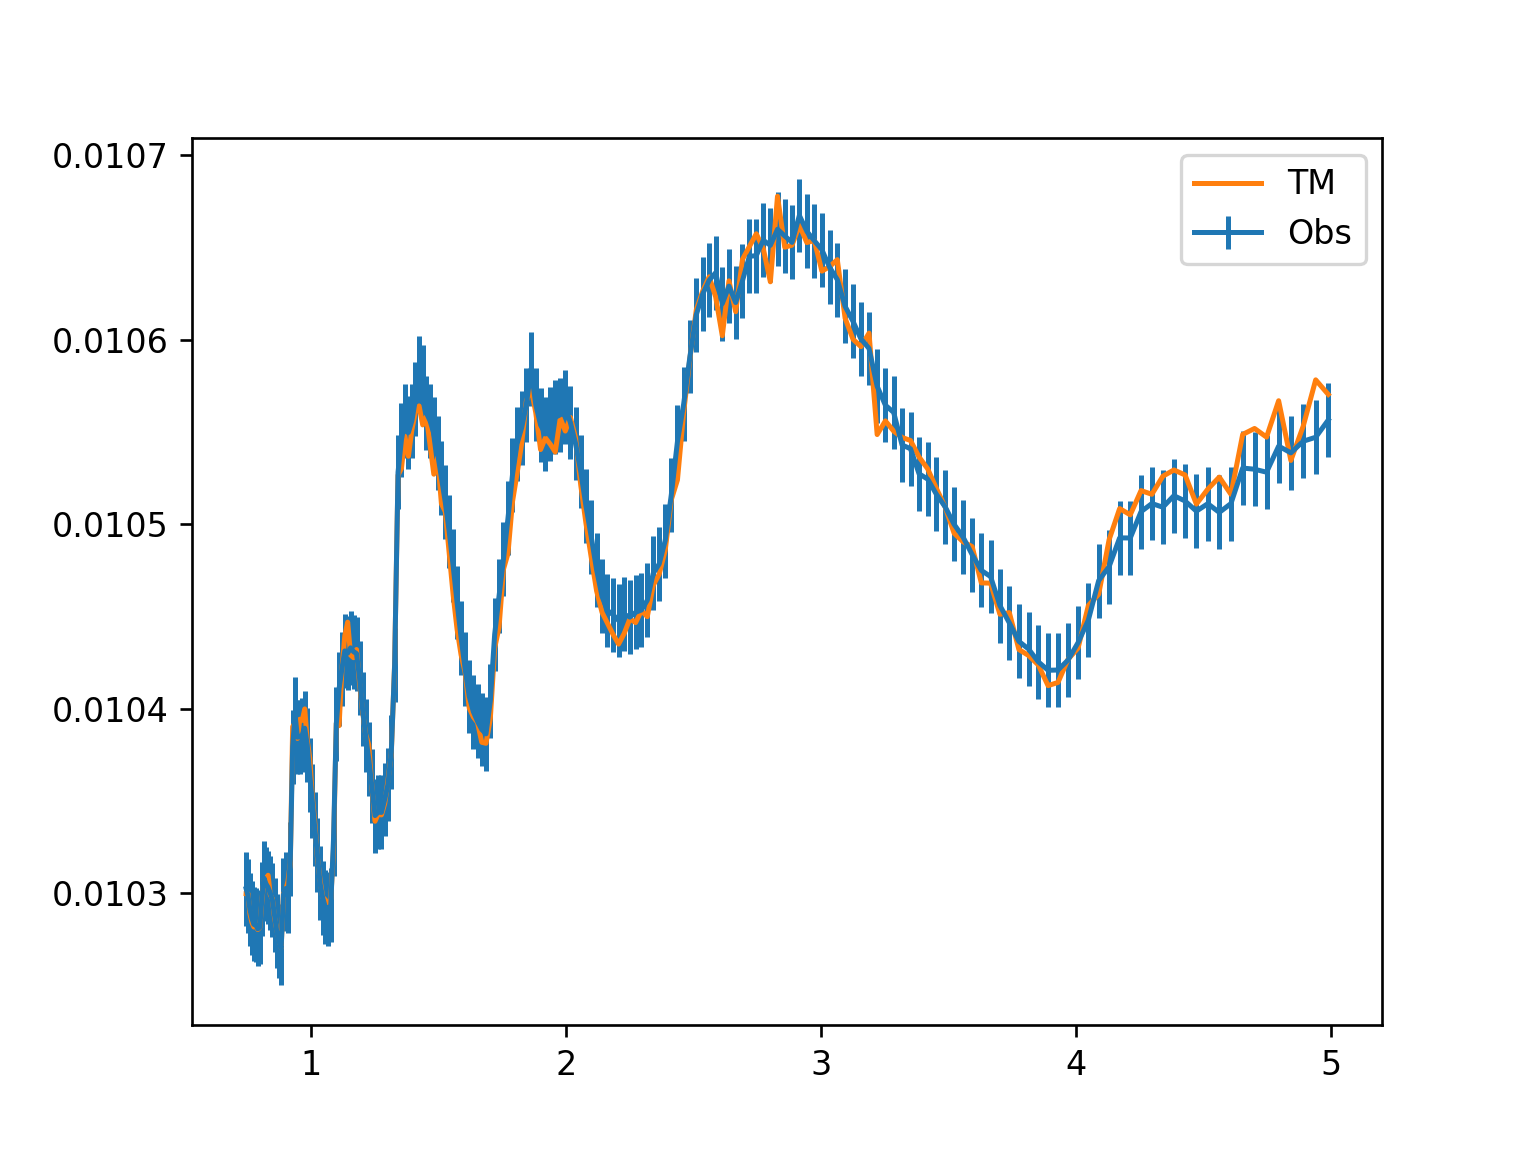

In [95]:
for solution,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.legend()
    plt.show()

Nice!